In [1]:
# -*- coding: utf-8 -*-
# Adapted from 2017 Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
from math import *

from scipy import integrate
from scipy import interpolate

class Orbiter:
    def __init__(self):
        
        #note, if d_ is used, it refers to dimensional quantity in SI units. 
        
        self.rE = rE = 6371000;
        self.mu_E = mu_E = (6.67*10**-11)*(5.972e24) #SI units
        self.hour  = hour = 3600 #seconds
        
        #set up non-d params
        
        self.lref = rE; #1 AU
        self.vref = sqrt(mu_E/self.lref) #v of earths orbit
        self.tref = self.lref/self.vref
        self.aref = (self.vref)**2/self.lref
        self.wref = 1/self.tref;
        
        self.d_mdry = 150; #kg
        
        #assign operating limits
        self.d_a_max = 0.2/self.d_mdry; #assuming 0.5N for vehicle mass of 5000 kg
        
        self.d_tf_max =100*hour;
        
        
        #assign initial conditions
        self.d_r0 = (6371+300)*1000;
        self.d_vr0 = 0;
        self.d_vt0 = sqrt(mu_E/(self.d_r0));
        self.d_w0 =self.d_vt0/self.d_r0; #earths orbital speed
        
        self.d_rf = (6371+1200)*1000;
        self.d_vrf = 0;
        self.d_final_apogee = (6371+3300)*1000;
        self.d_final_semimajor = (self.d_rf+self.d_final_apogee)/2;        
        self.d_vtf = sqrt(mu_E*(2/self.d_rf - 1/self.d_final_semimajor)); #vis viva equation at venus apogee.
        self.d_wf = self.d_vtf/self.d_rf;
        
        
        #non-dimensionalise
        self.u_max  = self.d_a_max/self.aref;
        self.r0     = self.d_r0 /self.lref;
        self.vr0    = self.d_vr0/self.vref;
        self.vt0    = self.d_vt0/self.vref;
        self.rf     = self.d_rf /self.lref;
        self.vrf    = self.d_vrf/self.vref;
        self.vtf    = self.d_vtf/self.vref;
        self.tf_max = self.d_tf_max/self.tref;
        self.w0     = self.d_w0/self.wref;


def dynamics(prob, obj, section):
    r   = prob.states(0, section)
    vr  = prob.states(1, section)
    vt  = prob.states(2, section)
    ur1 = prob.controls(0, section)
    ur2 = prob.controls(1, section)
    ut1 = prob.controls(2, section)
    ut2 = prob.controls(3, section)

    dx = Dynamics(prob, section)
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2 + (ur1 - ur2)
    dx[2] = - vr * vt / r + (ut1 - ut2)
    return dx()


def equality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    tf  = prob.time_final(-1)

    result = Condition()

    # event condition
    result.equal(r[0], obj.r0)
    result.equal(vr[0], obj.vr0)
    result.equal(vt[0], obj.vt0)
    result.equal(r[-1], obj.rf)
    result.equal(vr[-1], obj.vrf)
    result.equal(vt[-1], obj.vtf)
    
    return result()


def inequality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    tf  = prob.time_final(-1)

    result = Condition()

    # lower bounds
    result.lower_bound(r, 0.5*min(obj.r0,obj.rf))
    
    result.lower_bound(ur1, 0.0)
    result.lower_bound(ut1, 0.0)
    result.lower_bound(ur2, 0.0)
    result.lower_bound(ut2, 0.0)
    result.lower_bound(tf, 0.0)
    result.lower_bound(vt[-1],obj.vtf) #requries minimum final tangential speed, no upper bound set. 

    # upper bounds
    result.upper_bound(r, 2*max(obj.r0,obj.rf))
    result.upper_bound(np.sqrt(np.square(ur1-ur2) + np.square(ut1-ut2)), obj.u_max)
    #result.upper_bound(ut1, obj.u_max)
    #result.upper_bound(ur2, obj.u_max)
    #result.upper_bound(ut2, obj.u_max)
    result.upper_bound(tf, obj.tf_max)
    

    return result()


def cost(prob, obj):
    return 0.0


def running_cost(prob, obj):
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    
    netaccel = np.sqrt(np.square(ur1 - ur2) + np.square(ut1 - ut2));
    

    return netaccel

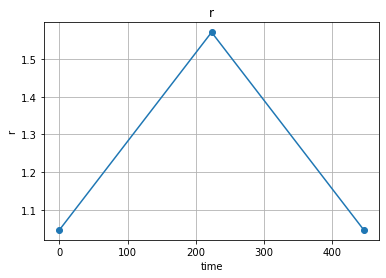

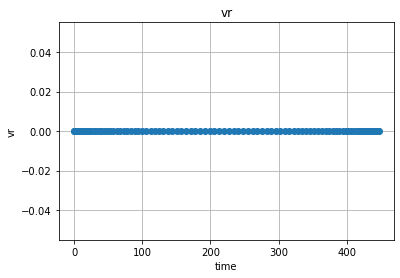

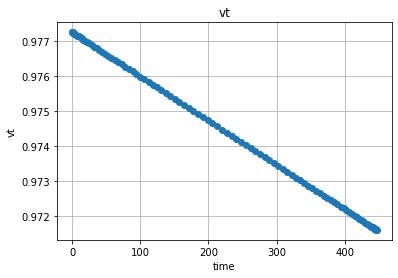

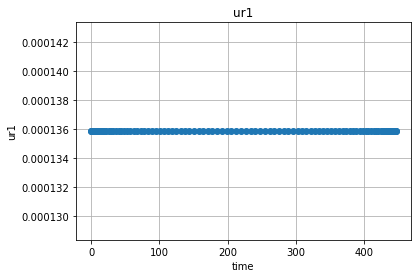

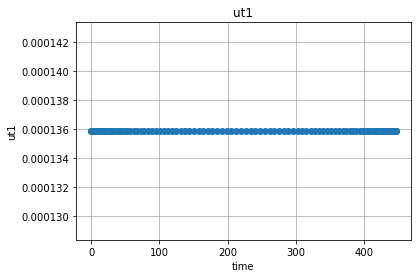

In [2]:
# ========================
plt.close("all")
plt.ion()
# Program Starting Point

obj = Orbiter()


time_init = [0.0, obj.tf_max]
n = [100]
num_states = [3]
num_controls = [4]
max_iteration = 6

flag_savefig = False

savefig_dir = "10_Low_Thrust_Orbit_Transfer/"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)


# ========================
# Initial parameter guess
t_guess  =                       [0, obj.tf_max/2, obj.tf_max]
r_guess  = [r*obj.r0    for r in [1, 1.5, 1.0]]

Guess.plot(t_guess,r_guess, "r", "time", "r")
if(flag_savefig):plt.savefig(savefig_dir + "guess_r" + savefig_add + ".png")

vr_init = Guess.linear(prob.time_all_section, obj.vr0, obj.vrf)
Guess.plot(prob.time_all_section, vr_init, "vr", "time", "vr")
if(flag_savefig):plt.savefig(savefig_dir + "guess_vr" + savefig_add + ".png")

vt_init = Guess.linear(prob.time_all_section, obj.vt0, obj.vtf)
Guess.plot(prob.time_all_section, vt_init, "vt", "time", "vt")
if(flag_savefig):plt.savefig(savefig_dir + "guess_vt" + savefig_add + ".png")

ur1_init = Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)

Guess.plot(prob.time_all_section, ur1_init, "ur1", "time", "ur1")
if(flag_savefig):plt.savefig(savefig_dir + "guess_ur1" + savefig_add + ".png")

ut1_init = Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)
Guess.plot(prob.time_all_section, ut1_init, "ut1", "time", "ut1")
if(flag_savefig):plt.savefig(savefig_dir + "guess_ut1" + savefig_add + ".png")

ur2_init = Guess.zeros(prob.time_all_section)
ut2_init = Guess.zeros(prob.time_all_section)

In [3]:
t_guess_f = prob.time_all_section;

r_interp = interpolate.interp1d(t_guess,r_guess)

prob.set_states_all_section(0,r_interp(t_guess_f))
prob.set_states_all_section(1, vr_init)
prob.set_states_all_section(2, vt_init)
prob.set_controls_all_section(0, ur1_init)
prob.set_controls_all_section(2, ut1_init)
prob.set_controls_all_section(1, ur2_init)
prob.set_controls_all_section(3, ut2_init)

# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
prob.running_cost = running_cost
prob.equality = equality
prob.inequality = inequality


def display_func():
    tf = prob.time_final(-1)
    rmax = max(prob.states_all_section(0))
    print("tf: {0:.5f} hours".format(tf*obj.tref/obj.hour))
    print("rmax: {0:.5f} rE".format(rmax))

In [ ]:
prob.solve(obj, display_func, ftol=1e-2)

---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.008577672179612144
            Iterations: 26
            Function evaluations: 18306
            Gradient evaluations: 26
Iteration limit exceeded
tf: 100.00000 hours
rmax: 1.54381 rE

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0035872543378959185
            Iterations: 26
            Function evaluations: 18328
            Gradient evaluations: 26
Iteration limit exceeded
tf: 100.00000 hours
rmax: 1.53815 rE

---- iteration : 3 ----


In [ ]:
# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
r = prob.states_all_section(0)
vr = prob.states_all_section(1)
vt = prob.states_all_section(2)
ur1 = prob.controls_all_section(0)
ur2 = prob.controls_all_section(1)
ut1 = prob.controls_all_section(2)
ut2 = prob.controls_all_section(3)
time = prob.time_update()

year = 3.154*10**7 #seconds

accel_mag=np.sqrt(np.square(ur1-ur2)+np.square(ut1-ut2))



# ------------------------
# Visualizetion
plt.figure()
plt.plot(time*obj.tref/year, r, marker=".", label="r")
for line in prob.time_knots():
    plt.axvline(line*obj.tref/year, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("r [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "r" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, vr, marker=".", label="vr")
plt.plot(time*obj.tref/year, vt, marker=".", label="vt")
for line in prob.time_knots():
    plt.axvline(line*obj.tref/year, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("velocity [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "velocity" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, (ur1 - ur2)*obj.aref, marker=".", label="ar")
plt.plot(time*obj.tref/year, (ut1 - ut2)*obj.aref, marker=".", label="at")
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("accel [m/s2]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, accel_mag, marker=".", label="a_mag")
plt.plot([0,time[-1]*obj.tref/year],[obj.u_max,obj.u_max],'k:')
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_mag [-]")
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, ur1, marker=".", label="ar_out")
plt.plot(time*obj.tref/year, ur2, marker=".", label="ar_in")
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_radial [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, ut1, marker=".", label="at_pro")
plt.plot(time*obj.tref/year, ut2, marker=".", label="at_retro")
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_tangential [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

if(flag_savefig): plt.savefig(savefig_dir + "thrust" + ".png")




theta = integrate.cumtrapz(vt / r, time, initial=0)
theta_f = interpolate.interp1d(time, theta)
r_f = interpolate.interp1d(time, r)
time_fine = np.linspace(time[0], time[-1], 1000)
r_fine = r_f(time_fine)
theta_fine = theta_f(time_fine)

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.plot(r_fine*np.cos(theta_fine), r_fine*np.sin(theta_fine))
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
if(flag_savefig): plt.savefig(savefig_dir + "trajectry" + ".png")


plt.show()


#plot the burn direction vector

helioxaccel = (ur1 - ur2)*np.cos(theta) - (ut1-ut2)*np.sin(theta)
helioyaccel = (ur1 - ur2)*np.sin(theta) + (ut1-ut2)*np.cos(theta)

fig = plt.figure()
plt.plot(time,helioxaccel,label='helio x')
plt.plot(time,helioyaccel, label='helio y')

plt.show()

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.quiver(r*np.cos(theta), r*np.sin(theta), helioxaccel,helioyaccel)
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
if(flag_savefig): plt.savefig(savefig_dir + "trajectry" + ".png")


plt.show()